![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import warnings
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)
data = data.astype('int')

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
import numpy as np

# Definición de la función mse para calular el mse 
def get_mse(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    #En caso no haya datos en alguno de los nodos, saco el mse solo del que si tiene
    mse_l = 0
    mse_r = 0
    if n_l != 0:
        mse_l = np.mean((y_l - np.mean(y_l)) ** 2)
    if n_r != 0:
        mse_r = np.mean((y_r - np.mean(y_r)) ** 2)
    
    mse = (n_l / (n_l + n_r) * mse_l) + (n_r / (n_l + n_r) * mse_r)
    
    return mse

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, -1]  # j, split, mse
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        #En caso haya mas de una particion
        if len(splits) > 0:
            # Para cada partición
            for split in splits:
                mse = get_mse(X.iloc[:, j], y, split)
                if best_split[2] == -1:
                    best_split = [j, split, mse]
                elif mse < best_split[2]:
                    best_split = [j, split, mse]
        
        #Si solo hay una particion, solo le saco el mse
        else:
            splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
            split = np.unique(splits)[0]
            mse = get_mse(X.iloc[:, j], y, split)
            
            if best_split[2] == -1:
                best_split = [j, split, mse]
            elif mse < best_split[2]:
                best_split = [j, split, mse]
            
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_mse=0, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0)
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean()) 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    # Revisar el criterio de parada 
    if mse < min_mse:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    # En caso de que hayan datos, busco la siguiente iteración para cada partición
    if len(X_l) > 0 and len(X_r) > 0:
        tree['split'] = [j, split]
        tree['sl'] = tree_grow(X_l, y_l, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)
        tree['sr'] = tree_grow(X_r, y_r, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

# Ejecución de función tree_predict
arbol_punto1 = tree_grow(X_train, y_train, level=0, min_mse=0, max_depth=3, num_pct=10)
y_pred = tree_predict(X_test, arbol_punto1)

#Evaluamos el modelo
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMSE: "+ str(rmse))
mae = np.mean(np.abs(y_pred - y_test))
print("MAE: " + str(mae))


RMSE: 1921.0068326673736
MAE: 1445.7898383371823


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap
# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_t = X_train.iloc[sample, :]
    y_t = y_train.iloc[sample]
    arbol_punto2 = tree_grow(X_t, y_t, level=0, num_pct=10, max_depth=5)
    y_pred.iloc[:,i] = tree_predict(X_test, arbol_punto2)

#Evaluamos el modelo
rmse = np.sqrt(np.mean((y_pred.mean(axis=1) - y_test)**2))
print("RMSE: "+ str(rmse))
mae = np.mean(np.abs(y_pred.mean(axis=1) - y_test))
print("MAE: " + str(mae))

RMSE: 1630.301655928008
MAE: 1210.8901558891446


Podemos observar que el desempeño del Bagging es superior al del árbol único, tal y como era de esperarse. El bagging ayuda a la predicción reduciendo la varianza y por consecuente el error en la estimacióm.

El RMSE en la muestra de validación pasó de ser 1921 a 1630, tras el apilamiento por bagging de 10 modelos. Por otro lado, el MAE paso de ser 1445 en el árbol único a 1210 en el bagging.

Un MAE de 1210 representa que en promedio la predicción tiene una distancia de 1210 con el valor real de la observación.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [8]:
# Celda 3

# Configuración del modelo Bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
# Ajustando el cálculo de max_features para asegurar que esté dentro del rango permitido
n_features = X_train.shape[1]
max_features = max(1, min(int(np.log(n_features)), n_features))

# Creación del modelo Bagging con DecisionTreeRegressor
bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    random_state=42,
    bootstrap=True,
    oob_score=True
)

# Entrenamiento del modelo
bagging_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_bagging = bagging_model.predict(X_test)

# Cálculo del RMSE
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))

rmse_bagging

2768.3504147769763

In [9]:
np.sqrt(mean_squared_error(y_test, y_pred_bagging))

2768.3504147769763

In [10]:
samples[0]

array([3582, 3454, 1346, ...,  826,  801, 5657])

In [11]:
bagging_model.oob_score_

0.28189093548768407

Podemos observar que el RMSE del Bagging de librería con un max_features igual al logaritmo de variables tiene un desempeño peor que el bagging previo construido de forma manual.

En concreto el modelo de bagging usando librerías tiene un RMSE de 2768.35 y un score OOB de 0.28.

Es posible que los patrones de predicción requieran de la combinación de varias variables y al limitar las variables por un max_feature considerablemente más bajo resulte en una peor predicción.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

# Creación del modelo de Random Forest para regresión
random_forest_model = RandomForestRegressor(n_estimators=10, random_state=42,oob_score = True )

# Entrenamiento del modelo
random_forest_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test)

# Cálculo del RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Otras métricas podrían incluir el R^2
r2_score_rf = random_forest_model.score(X_test, y_test)

rmse_rf, r2_score_rf

(1792.6732852279804, 0.7899027930207978)

In [13]:
random_forest_model.oob_score_

0.6127236124234927

Los resultados del Random Forest con librería devuelven un modelo con mejor desempeño que el bagging con librería, pero un desempeño peor que el bagging manual.

En concreto se obtuvo un RMSE de 1792, mayor al RMSE del bagging manual que asciende a 1630. Por otro lado, también se puede extrapolar que el R2 del modelo es de alrededor de 0.79, por lo que se puede concluir que el modelo de random forest captura el 79% de la varianza de la variable objetivo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

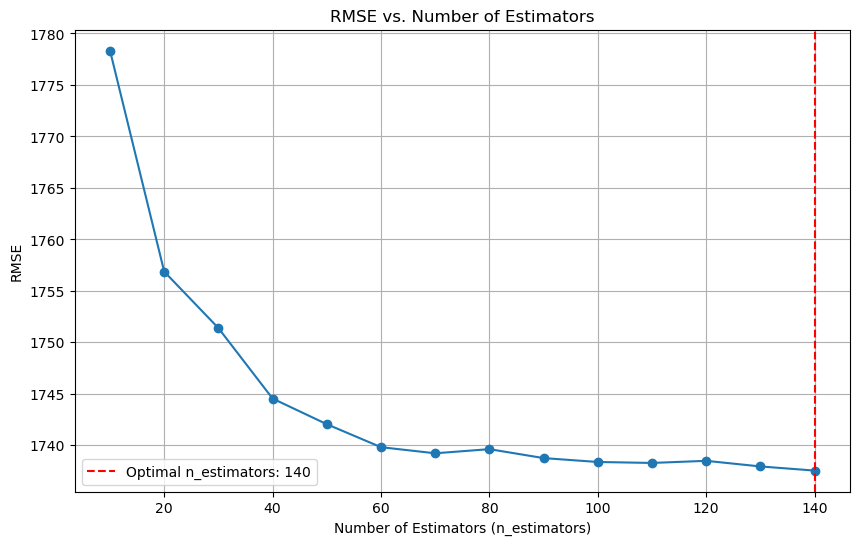

Optimal n_estimators: 140 with RMSE: 1737.5307877319342


In [14]:
# Celda 5
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
# Rango y almacenamiento de RMSE
n_estimators_range = range(10, 150, 10)
rmse_scores = []
for n_estimators in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, oob_score=True)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-scores.mean()))

# Encontrar el óptimo
optimal_n_estimators = n_estimators_range[np.argmin(rmse_scores)]
min_rmse = min(rmse_scores)

# Gráfico con línea óptima
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_scores, marker='o')
plt.axvline(x=optimal_n_estimators, color='r', linestyle='--', label=f'Optimal n_estimators: {optimal_n_estimators}')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal n_estimators: {optimal_n_estimators} with RMSE: {min_rmse}')

El parámetro n_estimators en un Random Forest indica el número de árboles de decisión que se utilizarán en el bosque. En general, agregar más árboles al bosque puede mejorar el rendimiento del modelo. A medida que aumenta el número de árboles, el modelo se vuelve más estable y menos propenso al sobreajuste. 

Sin embargo, en cierto punto, el aumento de árboles en un random forest representa un aumento marginal del desempeño y un coste computacional añadido, por tanto, se busca encontrar la cantidad de arboles donde el error de predicción se estabilice y un aumento de árboles no represente una mejora de consideración.

En la gráfica se puede observar que a partir de 100 arboles el algoritmo parece converger a cierto error, a pesar de esto escogemos la cantidad de arboles que minimice el error de predicción.

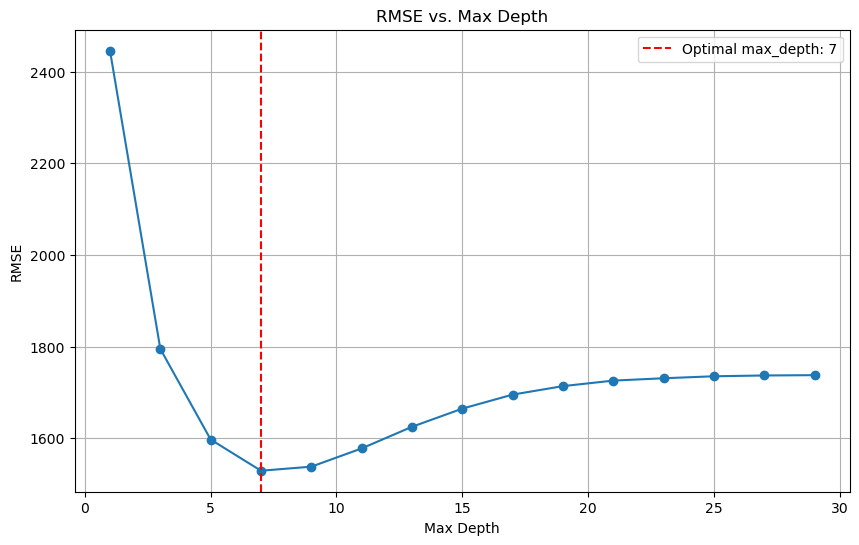

Optimal max_depth: 7 with RMSE: 1528.9611823143096


In [15]:
max_depth_range = range(1, 31, 2)
rmse_scores = []
for max_depth in max_depth_range:
    model = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42, oob_score=True)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-scores.mean()))

# Encontrar el óptimo
optimal_max_depth = max_depth_range[np.argmin(rmse_scores)]

# Gráfico con línea óptima
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, rmse_scores, marker='o')
plt.axvline(x=optimal_max_depth, color='r', linestyle='--', label=f'Optimal max_depth: {optimal_max_depth}')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal max_depth: {optimal_max_depth} with RMSE: {min(rmse_scores)}')


El hiperparámetro max_depth en un Random Forest controla la profundidad máxima de cada árbol de decisión individual en el bosque. Limitar la profundidad máxima de los árboles puede ayudar a prevenir el sobreajuste al evitar que los árboles sean demasiado complejos y se ajusten demasiado a los datos de entrenamiento. 

Podemos observar que existe un óptimo notable en una profundidad de 7. Si se agrega o disminuye profundidad a los árboles generarán un detrimento en el error en la muestra de validación.


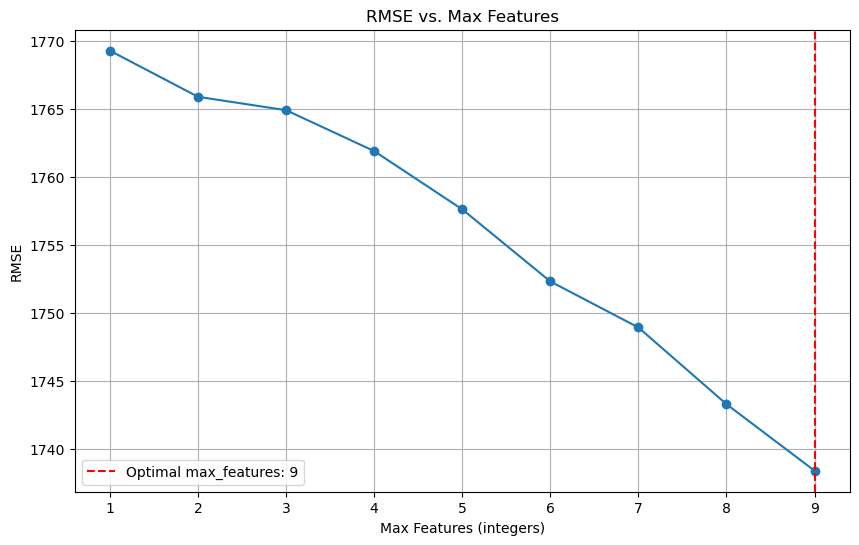

Optimal max_features: 9 with RMSE: 1738.3662548162006


In [16]:
# Suponiendo que X_train está definido y tiene, por ejemplo, 30 características
total_features = X_train.shape[1]  # Número total de características

# Definir un rango de valores enteros para max_features
max_features_values = range(1, total_features + 1)  # Desde 1 hasta el número total de características

# Almacenar el RMSE promedio para cada valor de max_features
rmse_scores = []

# Realizar validación cruzada para cada valor de max_features
for max_features in max_features_values:
    model = RandomForestRegressor(n_estimators=100, max_features=max_features, random_state=42, oob_score=True)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-scores.mean()))

# Encontrar el índice del mínimo RMSE
optimal_index = np.argmin(rmse_scores)
optimal_max_features = max_features_values[optimal_index]
min_rmse = rmse_scores[optimal_index]

# Gráfico del desempeño del modelo vs la cantidad de max_features
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, rmse_scores, marker='o')
plt.axvline(x=optimal_max_features, color='r', linestyle='--', label=f'Optimal max_features: {optimal_max_features}')
plt.xlabel('Max Features (integers)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Max Features')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal max_features: {optimal_max_features} with RMSE: {min_rmse}')


El hiperparámetro max_features en un Random Forest controla el número máximo de variables que se considerarán al buscar la mejor división en cada nodo del árbol de decisión.

Podemos observar que en este ejemplo puntual, el error del modelo en la muestra de validación se minimiza utilizando la totalidad de las variables. Podemos tambien observar una linealidad estricta entre la cantidad de columnas y el error.

Con los hiperparámetros encontrados hacemos una segunda busqueda de hiperparámetros óptimos mediante una busqueda con grilla. Utilizamos valores alrededor de los hiperparámetros encontrados en la busqueda secuencial con el fin de reducir la cantidad de combinaciones evaluadas.

In [17]:
from sklearn.model_selection import GridSearchCV
# Definición del modelo base
random_forest_model = RandomForestRegressor(random_state=42)

# Definición de la cuadrícula de parámetros
param_grid = {
    'n_estimators': [100, 150, 200],  # Puedes ajustar estos valores basado en tu presupuesto computacional
    'max_depth': [5, 7, 10],         # Profundidades razonables para probar
    'max_features': [5, 7, 9]        # Número de características basado en tu análisis previo
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Ejecución de la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

# Mejores parámetros y mejor score
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Mejores parámetros:", best_params)
print("Mejor score RMSE:", best_rmse)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ......max_depth=5, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=5, max_features=5, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=5, max_features=5, n_estimators=100; total time=   0.2s
[CV] END ......max_depth=5, max_features=5, n_estimators=100; total time=   0.2s
[CV] END ......max_depth=5, max_features=5, n_estimators=100; total time=   0.2s
[CV] END ......max_depth=5, max_features=5, n_estimators=150; total time=   0.4s
[CV] END ......max_depth=5, max_features=5, n_estimators=150; total time=   0.4s
[CV] END ......max_depth=5, max_features=5, n_estimators=150; total time=   0.4s
[CV] END ......max_depth=5, max_features=5, n_estimators=150; total time=   0.6s
[CV] END ......max_depth=5, max_features=5, n_estimators=150; total time=   0.5s
[CV] END ......max_depth=5, max_features=5, n_estimators=200; total time=   0.7s
[CV] END ......max_depth=5, max_features=5, n_e

In [18]:
random_forest_model = RandomForestRegressor(
    n_estimators=200,        # Optimal n_estimators
    max_depth=7,             # Optimal max_depth
    max_features=5,          # Optimal max_features
    random_state=42,
    oob_score=True           # Mantenemos el OOB score para referencia interna, aunque no lo reportaremos.
)

# Entrenamiento del modelo
random_forest_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test)

# Cálculo del RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Cálculo del MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Modelo Random Forest - RMSE en el conjunto de prueba  {rmse_rf}')
print(f'Modelo Random Forest - MAE en el conjunto de prueba: {mae_rf}')

Modelo Random Forest - RMSE en el conjunto de prueba  1558.7573540547864
Modelo Random Forest - MAE en el conjunto de prueba: 1146.5413893753007


En la nueva validación cruzada encontramos que hay un cambio, nos recomienda utilizar un hiperparámetro de max_features = 5 a diferencia con la busqueda secuencial que nos recomendaba max_features = 7. 

Esto nos devuelve un RMSE de 1558 y un MAE de 1146. Lo cual implica que en terminos absolutos, en promedio, las predicciones se desvian alrededor de 1146.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [19]:
# Celda 6
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
# import numpy as np

# Configurando el modelo XGBoost para regresión
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Cálculo del RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Cálculo del MAE
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)

RMSE: 1605.2355199928948
MAE: 1185.2272991506386


Implementando un modelo XGBoost sin hiperparámetros cross validados, es decir, con los valores por defecto encontramos un RMSE de 1605 y un MAE de 1185. 

Estos valores representan un mayor error en el modelo en comparación con el random forest previamente entrenado. Es posible que los hiperparámetros evaluados por defecto no encuentren un modelo óptimo.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

En primer lugar haremos una busqueda de hiperparámetros secuencial, encontrando el óptimo de los hiperparámetros uno a uno, manteniendo los demás constantes, para de esta forma poder observar como afecta cada hiperparámetro al desempeño del modelo. Posteriormente haremos una busqueda por grilla en una muestra más focalizada en valores alrededor de los óptimos iniciales.

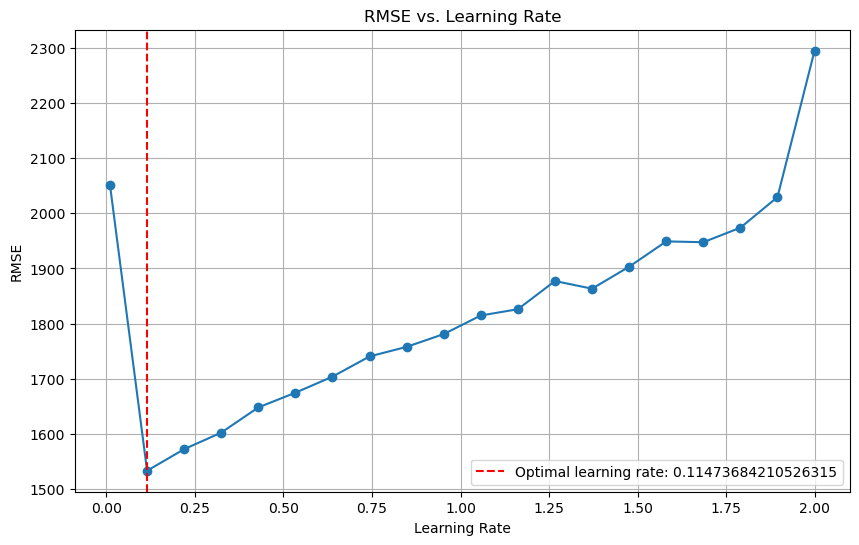

El learning rate óptimo es 0.11473684210526315 con un RMSE de 1533.4261988725468


In [20]:
# Celda 7
# Definición de los valores de learning_rate a probar
learning_rates = np.linspace(0.01, 2, 20)  # Valores entre 0.01 y 2

# Almacenar el RMSE promedio para cada valor de learning_rate
rmse_scores = []

# Realizar un 5-fold cross-validation para cada valor de learning_rate
for rate in learning_rates:
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=rate, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-scores.mean()))  # Convertir de MSE a RMSE

# Encontrar el índice del mínimo RMSE
min_rmse_index = np.argmin(rmse_scores)
# Encontrar el learning_rate que corresponde al mínimo RMSE
optimal_learning_rate = learning_rates[min_rmse_index]

# Gráfica del desempeño del modelo vs la cantidad de learning_rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, rmse_scores, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('RMSE vs. Learning Rate')
plt.grid(True)
plt.axvline(x=optimal_learning_rate, color='r', linestyle='--', label=f'Optimal learning rate: {optimal_learning_rate}')
plt.legend()
plt.show()

print(f'El learning rate óptimo es {optimal_learning_rate} con un RMSE de {min(rmse_scores)}')

La tasa de aprendizaje es un parámetro crucial que controla la contribución de cada árbol al modelo final. Se utiliza en conjunto con el número de árboles (n_estimators) para controlar la velocidad y la calidad del entrenamiento del modelo.

Si la tasa de aprendizaje es demasiado baja, existe el riesgo de que el modelo se estanque en un mínimo local subóptimo o incluso no converja en absoluto.

Por otro lado, una tasa de aprendizaje demasiado alta puede hacer que el modelo salte sobre el óptimo global y oscile alrededor de él, lo que puede llevar a un sobreajuste a los datos de entrenamiento.

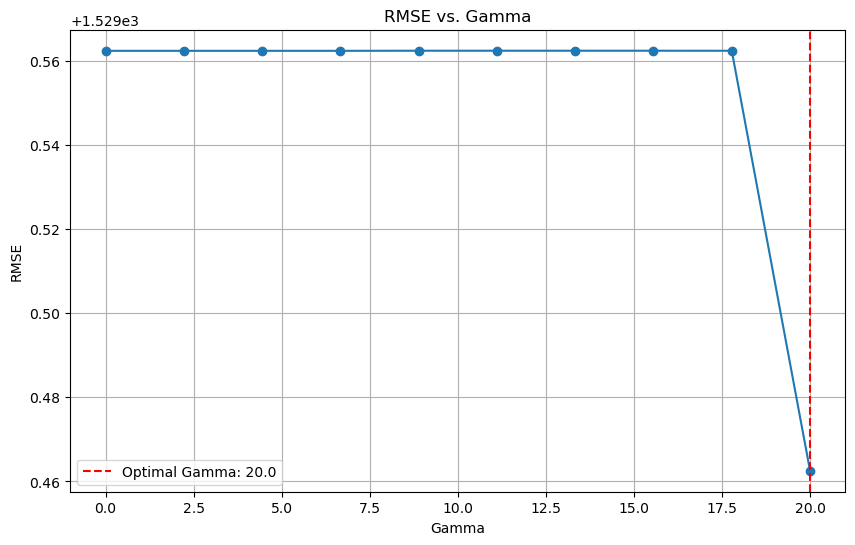

El gamma óptimo es 20.0 con un RMSE de 1529.4625458430278


In [21]:
# Definición de los valores de gamma a probar
gamma_values = np.linspace(0, 20, 10)  # Ejemplo: valores entre 0 y 0.5

# Almacenar el RMSE promedio para cada valor de gamma
rmse_scores = []

# Realizar un 5-fold cross-validation para cada valor de gamma
for gamma in gamma_values:
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, gamma=gamma, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-scores.mean()))  # Convertir de MSE a RMSE

# Encontrar el índice del mínimo RMSE
min_rmse_index = np.argmin(rmse_scores)
# Encontrar el gamma que corresponde al mínimo RMSE
optimal_gamma = gamma_values[min_rmse_index]

# Gráfica del desempeño del modelo vs la cantidad de gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, rmse_scores, marker='o')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.title('RMSE vs. Gamma')
plt.grid(True)
plt.axvline(x=optimal_gamma, color='r', linestyle='--', label=f'Optimal Gamma: {optimal_gamma}')
plt.legend()
plt.show()

print(f'El gamma óptimo es {optimal_gamma} con un RMSE de {min(rmse_scores)}')

El parámetro gamma en XGBoost es un hiperparámetro que controla cuánta reducción de la pérdida se requerirá para realizar una división en un nodo del árbol. 

Valor cero o muy bajo de gamma implica que no se aplicará ninguna penalización por complejidad al árbol.

Valor alto de gamma implica una penalización más fuerte por la complejidad del árbol. Conduce a árboles más simples y menos profundos durante el entrenamiento.

Podemos observar que no existe un efecto de reducción del error hasta el valor de gamma = 20, donde se observa una caída del error de predicción.

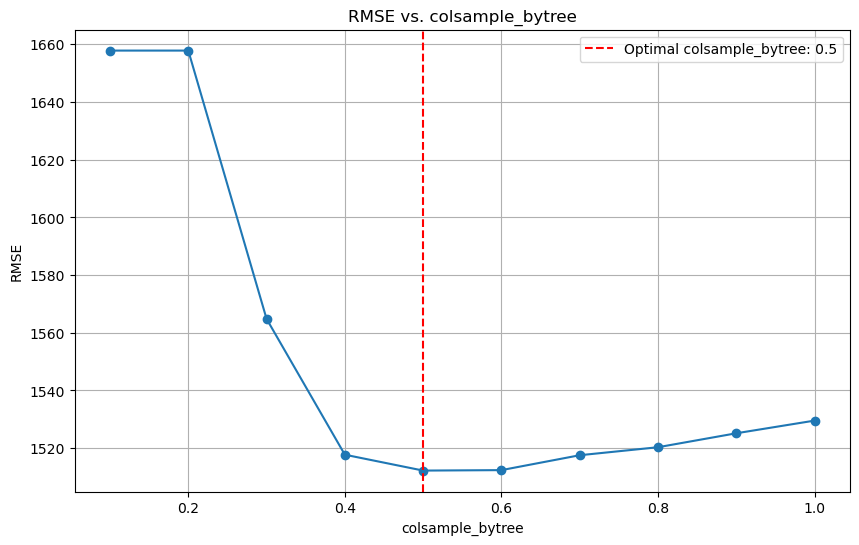

El colsample_bytree óptimo es 0.5 con un RMSE de 1512.2518587947768


In [22]:
# Definición de los valores de colsample_bytree a probar
colsample_bytree_values = np.linspace(0.1, 1.0, 10)  # Valores entre 0.1 y 1.0

# Almacenar el RMSE promedio para cada valor de colsample_bytree
rmse_scores = []

# Realizar un 5-fold cross-validation para cada valor de colsample_bytree
for colsample in colsample_bytree_values:
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, colsample_bytree=colsample, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-scores.mean()))  # Convertir de MSE a RMSE

# Encontrar el índice del mínimo RMSE
min_rmse_index = np.argmin(rmse_scores)
# Encontrar el colsample_bytree que corresponde al mínimo RMSE
optimal_colsample_bytree = colsample_bytree_values[min_rmse_index]

# Gráfica del desempeño del modelo vs la cantidad de colsample_bytree
plt.figure(figsize=(10, 6))
plt.plot(colsample_bytree_values, rmse_scores, marker='o')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')
plt.title('RMSE vs. colsample_bytree')
plt.grid(True)
plt.axvline(x=optimal_colsample_bytree, color='r', linestyle='--', label=f'Optimal colsample_bytree: {optimal_colsample_bytree}')
plt.legend()
plt.show()

print(f'El colsample_bytree óptimo es {optimal_colsample_bytree} con un RMSE de {min(rmse_scores)}')



El parámetro colsample_bytree en XGBoost es un hiperparámetro que controla la proporción de columnas que se utilizarán al construir cada árbol en el modelo. Al seleccionar aleatoriamente solo un subconjunto de características para cada árbol, se reduce la correlación entre los árboles individuales en el modelo, lo que puede ayudar a reducir la varianza y mejorar la generalización del modelo.

Podemos observar que el colsample_bytree obtiene su valor mínimo en 0.5, inplicando la selección solo de la mitad de las caracteristicas presentes en la base de entrenamiento. Un aumento o disminución de este hiperparámetro significará un aumento del error.

In [23]:
# Configurando el modelo XGBoost para regresión
xgb_model = XGBRegressor(objective='reg:squarederror',learning_rate=optimal_learning_rate, n_estimators=100, colsample_bytree=optimal_colsample_bytree,gamma=optimal_gamma,  random_state=42)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Cálculo del RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Cálculo del MAE
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)

RMSE: 1546.8378489563486
MAE: 1137.6471749321142


Despues de la selección secuencial de los hiperparámetros realizamos el entrenamiento del modelo para evaluar el desempeño de este en la muestra de validación. Podemos obsevar que el RMSE asciende a 1546 y el MAE a 1137. Un desempeño algo superior al obtenido en el modelo de Random Forest.

Sin embargo, para reducir aún más el error procedemos a una busqueda de hiperparámetros mediante una grilla alimentada con valores cercanos a los óptimos encontrados en el ejercicio previo.

In [24]:
from sklearn.model_selection import GridSearchCV

# Definición del modelo base
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Definición de la cuadrícula de parámetros
param_grid = {
    'learning_rate': [0.10,0.105,0.11,0.115,0.12,0.125,0.13,0.135],
    'gamma': [0, 20],
    'colsample_bytree': [0.25, 0.5, 1]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Ejecución de la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

# Mejores parámetros y mejor score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[CV] END ..colsample_bytree=0.25, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ..colsample_bytree=0.25, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ..colsample_bytree=0.25, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ..colsample_bytree=0.25, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ..colsample_bytree=0.25, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END colsample_bytree=0.25, gamma=0, learning_rate=0.105; total time=   0.0s
[CV] END colsample_bytree=0.25, gamma=0, learning_rate=0.105; total time=   0.0s
[CV] END colsample_bytree=0.25, gamma=0, learning_rate=0.105; total time=   0.0s
[CV] END colsample_bytree=0.25, gamma=0, learning_rate=0.105; total time=   0.0s
[CV] END colsample_bytree=0.25, gamma=0, learning_rate=0.105; total time=   0.0s
[CV] END .colsample_bytree=0.25, gamma=0, learning_rate=0.11; total time=   0.0s
[CV] END .colsample_bytree=0.25, gamma=0, learning_rate=0.11; total time=   0.0s
[CV] END .colsample_bytree=0

Los mejores hiperparámetros encontrdos en la busqueda de mediante grilla corresponden a:

Learning Rate = 0.12
Gamma = 0
Colsample by tree = 0.5

In [25]:
# Configuración del modelo XGBoost
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.12,
    gamma=0,
    colsample_bytree=0.5,
    random_state=42
)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)  # Calcular MAE

print(f'RMSE en el conjunto de prueba: {rmse_xgb}')
print(f'MAE en el conjunto de prueba: {mae_xgb}')  # Imprimir MAE

RMSE en el conjunto de prueba: 1545.9614714583167
MAE en el conjunto de prueba: 1137.2620827055969


Podemos observar que existe una disminución del error marginal con respecto a la etapa previa del modelo XGBoost con hiperoarámetros encontrados secuencialmente. Alcanzando un RMSE en testing de 1545.96 y un MAE de 1137.26. 

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [26]:
# Celda 8
import plotly.graph_objects as go
# Creación de gráficos
# Creación de gráficos
fig = go.Figure(data=[
    go.Bar(name='Random Forest', x=['RMSE', 'MAE'], y=[rmse_rf, mae_rf], marker_color='indianred',
           text=['Random Forest', 'Random Forest'], textposition='inside', textfont=dict(color='white')),
    go.Bar(name='XGBoost', x=['RMSE', 'MAE'], y=[rmse_xgb, mae_xgb], marker_color='lightblue',
           text=['XGBoost', 'XGBoost'], textposition='inside', textfont=dict(color='white'))
])

# Actualización de diseño para hacerlo más legible
fig.update_layout(
    title='Comparación de RMSE y MAE entre Random Forest y XGBoost',
    xaxis_title='Métrica',
    yaxis_title='Valor',
    barmode='group',
    bargap=0.15,  # Ajusta el espacio entre las barras de diferentes grupos
    bargroupgap=0.1  # Ajusta el espacio entre barras del mismo grupo
)

# Añadir etiquetas con valores encima de cada barra
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside', textfont=dict(color='black'))

# Mostrar gráfico
fig.show()

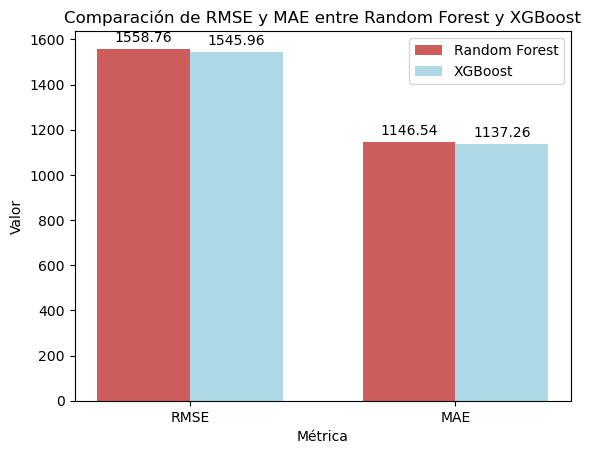

In [28]:
metrics = ['RMSE', 'MAE']

bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots()

bar_rf = ax.bar(index, [rmse_rf, mae_rf], bar_width, label='Random Forest', color='indianred')
bar_xgb = ax.bar([p + bar_width for p in index], [rmse_xgb, mae_xgb], bar_width, label='XGBoost', color='lightblue')

# Etiquetas de los ejes y título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valor')
ax.set_title('Comparación de RMSE y MAE entre Random Forest y XGBoost')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(metrics)

# Añadir etiquetas con valores redondeados a 2 decimales encima de cada barra
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar_rf)
add_labels(bar_xgb)

# Añadir leyenda
ax.legend()

# Mostrar gráfico
plt.show()

En esta gráfica podemos observar las diferencias entre los modelos Random Forest y XGBoost. Podemos observar que tanto en el RMSE, como en el MAE el modelo XGBoost tiene un mejor desempeño en métricas. A pesar de esto, se puede también concluir que las diferencias entre los modelos no aparenta ser muy alta. En concreto la diferencia en el error absoluto medio es de alrededor de 9.28, que sobre el error global del XGBoost representa un 0.81%.

Una de las razones por las cuales el XGBoost puede tener un mejor desempeño que el Random Forest es quiza su capacidad de regularización que pueden ayudar a prevenir el sobreajuste.

Por otro lado, aunque Random Forest puede capturar relaciones no lineales en los datos, su capacidad para modelar relaciones complejas es limitada en comparación con XGBoost. XGBoost utiliza una técnica de boosting que combina árboles débiles de manera secuencial, lo que le permite capturar patrones más complejos y sutiles en los datos al basarse de los errores previos para focalizar la atención de los modelo subsiguientes.